In [1]:
from torchvision import datasets, transforms
import torch
def calculate_mean_std(dataset):
    """calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# normalization transform
transform = transforms.Compose([transforms.ToTensor()])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

mean, std = calculate_mean_std(trainset)
print(f'Before normalization: mean: {mean}, std: {std}')

# normalization transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

mean, std = calculate_mean_std(trainset)
print(f'After normalization: mean: {mean}, std: {std}')

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Before normalization: mean: 0.28604063391685486, std: 0.3204546272754669
After normalization: mean: -7.240076627113012e-08, std: 0.9999945759773254
Using device: cuda


[epoch 1] train loss: 0.4958, test loss: 0.5043, accuracy: 80.60%, precision: 18.98%, recall: 18.02%, f1_score: 18.48%
Validation loss decreased (inf --> 0.504282).  Saving model ...
[epoch 2] train loss: 0.4095, test loss: 0.5340, accuracy: 80.94%, precision: 18.22%, recall: 18.08%, f1_score: 18.15%
EarlyStopping counter: 1 out of 5
[epoch 3] train loss: 0.3923, test loss: 0.4222, accuracy: 84.30%, precision: 19.21%, recall: 18.84%, f1_score: 19.02%
Validation loss decreased (0.504282 --> 0.422192).  Saving model ...
[epoch 4] train loss: 0.3849, test loss: 0.4564, accuracy: 83.39%, precision: 18.25%, recall: 18.63%, f1_score: 18.43%
EarlyStopping counter: 1 out of 5
[epoch 5] train loss: 0.3776, test loss: 0.4613, accuracy: 84.09%, precision: 19.09%, recall: 18.79%, f1_score: 18.93%
EarlyStopping counter: 2 out of 5


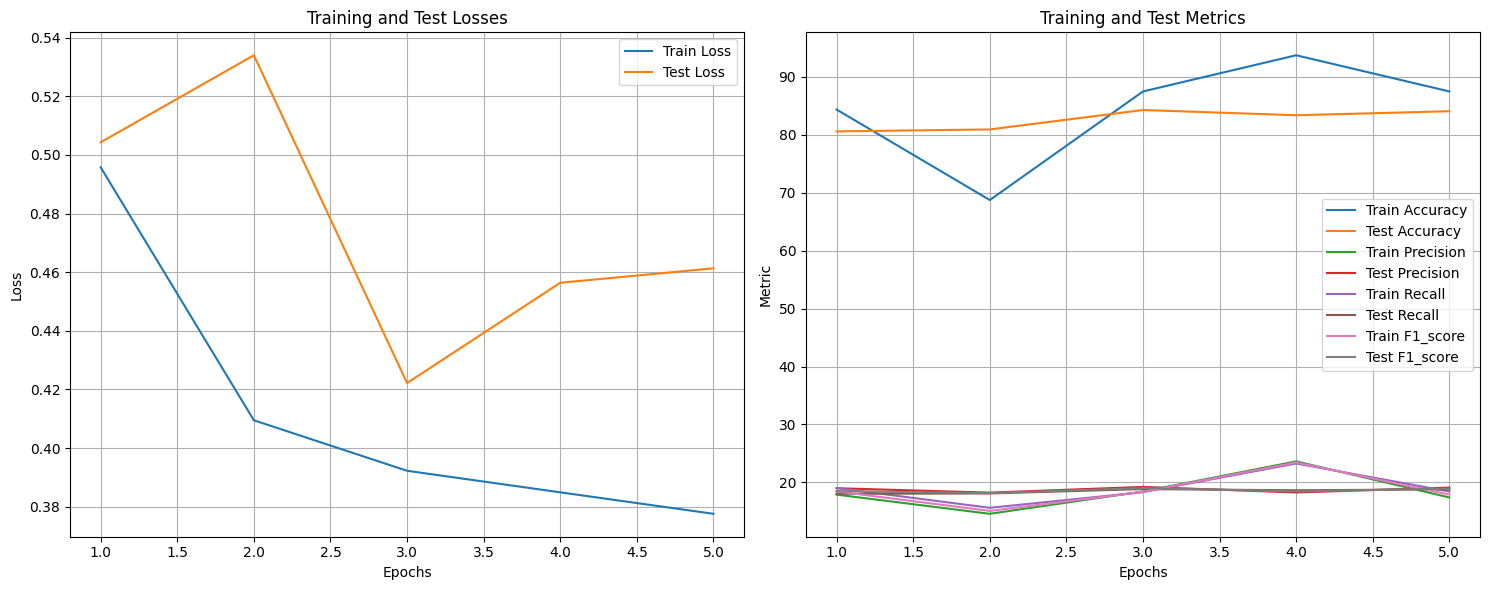

In [8]:
import torch
import torch.nn as nn
from torch.optim import Adadelta
import sys
from pathlib import Path

utils_dir = Path('/home/gustaf/projects/deeplearning/utils')
sys.path.append(str(utils_dir))
from metrics import precision, recall, f1_score
from trainer import ModelTrainer


# model
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize model
model = SimpleNet(input_size=28*28, output_size=10)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=Adadelta(model.parameters(), lr=1, weight_decay=0.002),
    batch_size=64,
    verbose=True,
    early_stopping_patience=5,
    metrics=[ModelTrainer.accuracy, precision, recall, f1_score]
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    test_set=testset,
    num_epochs=5
)

In [2]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages',
 '/tmp/tmp6wk5mg6e']